In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [14]:
input_dir1 = './MPD_dataset/MPD_events'
input_dir2 = './answers'

ratio_list = []

for evtid in range(800, 1000):
    event_name = input_dir1 + f'/event_{evtid}_'
    answer_name = input_dir2 + f'/answer_{evtid-800}.csv'
    print(f'Processing: {event_name:s} & {answer_name:s}')

    hits = pd.read_csv(event_name + 'hits.csv')
    pred = pd.read_csv(answer_name)
    if not hits.empty:
        hits = hits[['hit_id', 'row_id', 'sector_id']]
        
        tracks = pd.read_csv(event_name + 'tracks.csv')
        truth = pd.read_csv(event_name + 'truth.csv')

        truth = truth.merge(tracks[['track_id', 'pt']], on='track_id')
        hits = hits.merge(truth, on='hit_id')
        
        hits = hits[hits['pt'] >= 0.15]

        if not hits.empty:
            track_ids = set(hits["track_id"])

            ratio = []
            
            for tr in track_ids:
                track_hits = hits[hits["track_id"] == tr].copy().sort_values('row_id')
    
                pairs = pd.DataFrame({
                    'hit_id_1': track_hits['hit_id'],
                    'hit_id_2': track_hits['hit_id'].shift(-1),
                    'row_id_1': track_hits['row_id'],
                    'row_id_2': track_hits['row_id'].shift(-1),
                    'sector_id_1': track_hits['sector_id'],
                    'sector_id_2': track_hits['sector_id'].shift(-1)
                })

                pairs = pairs.dropna().astype({'hit_id_1': int,
                                               'hit_id_2': int,
                                               'row_id_1': int,
                                               'row_id_2': int,
                                               'sector_id_1': int,
                                               'sector_id_2': int})

                valid_pairs = pairs[
                    (pairs['row_id_1'] + 1 == pairs['row_id_2']) & 
                    (pairs['sector_id_1'] == pairs['sector_id_2'])
                ]

                track_seg_num = valid_pairs[['row_id_1', 'row_id_2']].drop_duplicates().shape[0]

                merged = valid_pairs.merge(
                    pred,
                    left_on=['hit_id_1', 'hit_id_2'],
                    right_on=['in_hit_id', 'out_hit_id']
                )

                pred_seg_num = merged[['row_id_1', 'row_id_2']].drop_duplicates().shape[0]

                ratio.append(pred_seg_num / track_seg_num if track_seg_num else 0)
            
            ratio_list.append(ratio)


Processing: ./MPD_dataset/MPD_events/event_800_ & ./answers/answer_0.csv
Processing: ./MPD_dataset/MPD_events/event_801_ & ./answers/answer_1.csv
Processing: ./MPD_dataset/MPD_events/event_802_ & ./answers/answer_2.csv
Processing: ./MPD_dataset/MPD_events/event_803_ & ./answers/answer_3.csv
Processing: ./MPD_dataset/MPD_events/event_804_ & ./answers/answer_4.csv
Processing: ./MPD_dataset/MPD_events/event_805_ & ./answers/answer_5.csv
Processing: ./MPD_dataset/MPD_events/event_806_ & ./answers/answer_6.csv
Processing: ./MPD_dataset/MPD_events/event_807_ & ./answers/answer_7.csv
Processing: ./MPD_dataset/MPD_events/event_808_ & ./answers/answer_8.csv
Processing: ./MPD_dataset/MPD_events/event_809_ & ./answers/answer_9.csv
Processing: ./MPD_dataset/MPD_events/event_810_ & ./answers/answer_10.csv
Processing: ./MPD_dataset/MPD_events/event_811_ & ./answers/answer_11.csv
Processing: ./MPD_dataset/MPD_events/event_812_ & ./answers/answer_12.csv
Processing: ./MPD_dataset/MPD_events/event_813_ 

In [15]:
ratio_list = [item for sublist in ratio_list for item in sublist]

In [16]:
rlen = len(ratio_list)

xlist = [x / 100 for x in list(range(50, 102, 2))]

eff = [sum(1 for num in ratio_list if num >= x) / rlen for x in xlist]

In [17]:
eff

[0.9431701088660902,
 0.9370771918820842,
 0.9351283544644057,
 0.9327315084449621,
 0.9296850499529591,
 0.927243403073339,
 0.9223825097441871,
 0.9182608306079477,
 0.9144079566327673,
 0.9067022086824067,
 0.901684512342637,
 0.8939339635320999,
 0.8856458043994445,
 0.874826396666816,
 0.8634469781819811,
 0.8518435553962637,
 0.8319519734778907,
 0.8112315756462524,
 0.786255096097845,
 0.7554097038663142,
 0.717485775726894,
 0.6670176067380493,
 0.6056852291563998,
 0.5314278034138256,
 0.43707719188208416,
 0.3860714125711214]

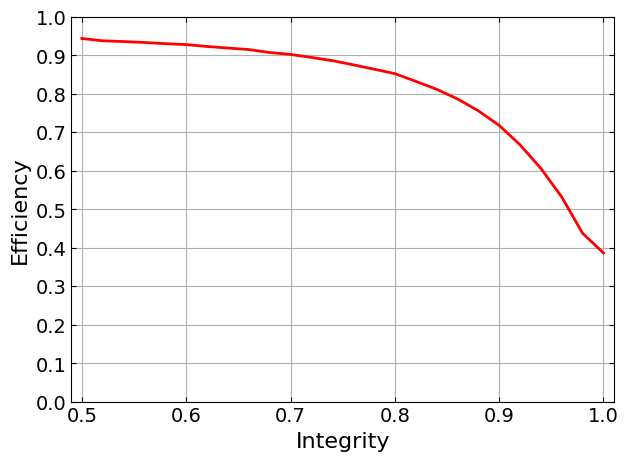

In [20]:
plt.figure(figsize=(7, 5))
plt.plot(xlist, eff, alpha=1, label='Efficiency', linewidth=2, color='red')
plt.xlim([0.49, 1.01])
plt.ylim([0, 1])
plt.xlabel('Integrity', fontsize=16)
plt.ylabel('Efficiency', fontsize=16)
plt.tick_params(axis='both', 
                which='major', 
                labelsize=14,
                top=True,
                bottom=True,
                left=True,
                right=True,
                direction='in')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.show()
#plt.savefig("Efficiency_vs_Integrity.pdf")